In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mlp-term-3-2025-kaggle-assignment-3/sample_submission.csv
/kaggle/input/mlp-term-3-2025-kaggle-assignment-3/train.csv
/kaggle/input/mlp-term-3-2025-kaggle-assignment-3/test.csv


In [2]:
# =============================================================================
# SECTION 1: ENVIRONMENT SETUP
# =============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string

# Sklearn imports
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# NLTK for text processing
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

# Scipy for sparse matrices
from scipy.sparse import hstack

import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

In [3]:
# =============================================================================
# SECTION 2: DATA LOADING
# =============================================================================
train = pd.read_csv('/kaggle/input/mlp-term-3-2025-kaggle-assignment-3/train.csv')
test = pd.read_csv('/kaggle/input/mlp-term-3-2025-kaggle-assignment-3/test.csv')
sample_sub = pd.read_csv('/kaggle/input/mlp-term-3-2025-kaggle-assignment-3/sample_submission.csv')

print(f"Training data shape: {train.shape}")
print(f"Test data shape: {test.shape}")
print(f"Sample submission shape: {sample_sub.shape}")

print("First few rows of training data:")
print(train.head())

Training data shape: (7000, 6)
Test data shape: (1700, 5)
Sample submission shape: (1700, 2)
First few rows of training data:
   id                                             phrase  feature_1  \
0   0  It may as well be called `` Jar-Jar Binks : Th...       14.0   
1   1                               You have to see it .        6.0   
2   2  ... either you 're willing to go with this cla...       16.0   
3   3  Watching Harris ham it up while physically and...       37.0   
4   4  Pete 's screenplay manages to find that real n...       20.0   

   feature_2  feature_3  sentiment  
0        5.0        7.0          0  
1        1.0        NaN          2  
2        0.0        6.0          1  
3        NaN        3.0          1  
4        1.0        4.0          2  


In [4]:
# =============================================================================
# SECTION 3: DATA TYPE IDENTIFICATION 
# =============================================================================
print("\nData types of all columns in training set:")
print(train.dtypes)

print("\nDetailed data type information:")
for col in train.columns:
    dtype = train[col].dtype
    unique_count = train[col].nunique()
    print(f"  • {col:15s} -> {str(dtype):10s} (Unique values: {unique_count})")

print("Data types identified:")
print(f"  • Numerical columns: feature_1, feature_2, feature_3, sentiment")
print(f"  • Text column: phrase")
print(f"  • ID column: id")


Data types of all columns in training set:
id             int64
phrase        object
feature_1    float64
feature_2    float64
feature_3    float64
sentiment      int64
dtype: object

Detailed data type information:
  • id              -> int64      (Unique values: 7000)
  • phrase          -> object     (Unique values: 6823)
  • feature_1       -> float64    (Unique values: 52)
  • feature_2       -> float64    (Unique values: 15)
  • feature_3       -> float64    (Unique values: 20)
  • sentiment       -> int64      (Unique values: 3)
Data types identified:
  • Numerical columns: feature_1, feature_2, feature_3, sentiment
  • Text column: phrase
  • ID column: id


In [5]:
# =============================================================================
# SECTION 4: DESCRIPTIVE STATISTICS 
# =============================================================================
numerical_cols_orig = ['feature_1', 'feature_2', 'feature_3', 'sentiment']

print("Descriptive statistics for numerical columns:")
print(train[numerical_cols_orig].describe())

print("Detailed statistics for each numerical column:")
for col in numerical_cols_orig:
    print(f"\n{col}:")
    print(f"  • Min value:    {train[col].min():.4f}")
    print(f"  • Max value:    {train[col].max():.4f}")
    print(f"  • Mean:         {train[col].mean():.4f}")
    print(f"  • Median:       {train[col].median():.4f}")
    print(f"  • Std Dev:      {train[col].std():.4f}")
    print(f"  • 25th percentile: {train[col].quantile(0.25):.4f}")
    print(f"  • 75th percentile: {train[col].quantile(0.75):.4f}")

print("Descriptive statistics computed for all numerical columns")

Descriptive statistics for numerical columns:
         feature_1    feature_2    feature_3    sentiment
count  6088.000000  5896.000000  5938.000000  7000.000000
mean     19.025624     1.996608     3.334119     1.041143
std       9.303562     1.634858     2.321154     0.898010
min       1.000000     0.000000     0.000000     0.000000
25%      12.000000     1.000000     2.000000     0.000000
50%      18.000000     1.000000     3.000000     1.000000
75%      25.000000     3.000000     4.000000     2.000000
max      52.000000    19.000000    19.000000     2.000000
Detailed statistics for each numerical column:

feature_1:
  • Min value:    1.0000
  • Max value:    52.0000
  • Mean:         19.0256
  • Median:       18.0000
  • Std Dev:      9.3036
  • 25th percentile: 12.0000
  • 75th percentile: 25.0000

feature_2:
  • Min value:    0.0000
  • Max value:    19.0000
  • Mean:         1.9966
  • Median:       1.0000
  • Std Dev:      1.6349
  • 25th percentile: 1.0000
  • 75th percentile: 

### Key Insights from Descriptive Statistics

- **Features have different scales**  
  - `feature_1` ranges **1–52** (wide spread)  
  - `feature_2` and `feature_3` are much smaller (mostly **0–4**)  
  → *Scaling is necessary.*

- **Distribution patterns**  
  - `feature_1` is roughly **symmetric**  
  - `feature_2` and `feature_3` are **right-skewed** but concentrated in low values  

- **Variability differences**  
  - `feature_1` has the **highest variance**  
  - `feature_2` has the **tightest distribution**  

- **Target variable (sentiment)**  
  - Values range from **0 to 2** with median **1**  
  - Indicates a **3-class setup** with mid-sentiment centered  


Descriptive statistics confirm clean data with meaningful variation across features.  

In [6]:
# =============================================================================
# SECTION 5: MISSING VALUE ANALYSIS 
# =============================================================================

print("\nChecking for missing values in training data:")
missing_train = train.isnull().sum()
print(missing_train)

print("\nMissing value percentages:")
missing_pct = (train.isnull().sum() / len(train)) * 100
missing_df = pd.DataFrame({
    'Column': missing_train.index,
    'Missing_Count': missing_train.values,
    'Missing_Percentage': missing_pct.values
})
print(missing_df)


Checking for missing values in training data:
id              0
phrase          0
feature_1     912
feature_2    1104
feature_3    1062
sentiment       0
dtype: int64

Missing value percentages:
      Column  Missing_Count  Missing_Percentage
0         id              0            0.000000
1     phrase              0            0.000000
2  feature_1            912           13.028571
3  feature_2           1104           15.771429
4  feature_3           1062           15.171429
5  sentiment              0            0.000000


In [7]:
print("Checking for missing values in test data:")
missing_test = test.isnull().sum()
print(missing_test)

print("=" * 80)
print("Missing Value Handling Strategy:")
if train.isnull().sum().sum() > 0:
    print("Missing values detected in numerical features")
    print("Strategy: Imputation using MEDIAN (robust to outliers)")
    print("Rationale: Median is less affected by extreme values")
    print("=" * 80)
    
    # Apply imputation to training data
    imputer_initial = SimpleImputer(strategy='median')
    train[['feature_1', 'feature_2', 'feature_3']] = imputer_initial.fit_transform(
        train[['feature_1', 'feature_2', 'feature_3']]
    )
    
    # Apply imputation to test data
    test[['feature_1', 'feature_2', 'feature_3']] = imputer_initial.transform(
        test[['feature_1', 'feature_2', 'feature_3']]
    )
    
    print("Imputation completed!")
    print(f"Training data missing values after imputation: {train.isnull().sum().sum()}")
    print(f"Test data missing values after imputation: {test.isnull().sum().sum()}")
    
print("=" * 80)
print("Missing value analysis and handling complete")

Checking for missing values in test data:
id             0
phrase         0
feature_1    222
feature_2    318
feature_3     90
dtype: int64
Missing Value Handling Strategy:
Missing values detected in numerical features
Strategy: Imputation using MEDIAN (robust to outliers)
Rationale: Median is less affected by extreme values
Imputation completed!
Training data missing values after imputation: 0
Test data missing values after imputation: 0
Missing value analysis and handling complete


In [8]:
# =============================================================================
# SECTION 6: DUPLICATE DETECTION 
# =============================================================================

# Check for duplicate rows
duplicates_train = train.duplicated().sum()
print(f"\nNumber of duplicate rows in training data: {duplicates_train}")

# Check for duplicate IDs
duplicate_ids_train = train['id'].duplicated().sum()
print(f"Number of duplicate IDs in training data: {duplicate_ids_train}")

# Check for duplicate phrases
duplicate_phrases = train['phrase'].duplicated().sum()
print(f"Number of duplicate phrases in training data: {duplicate_phrases}")


Number of duplicate rows in training data: 0
Number of duplicate IDs in training data: 0
Number of duplicate phrases in training data: 177


### Duplicate Phrases Handling

**Action:** **Retained**

**Rationale:**  
- The same phrase can carry different sentiment labels  
- Context and surrounding text influence sentiment interpretation  

In [9]:
# =============================================================================
# SECTION 7: OUTLIER ANALYSIS 
# =============================================================================

def detect_outliers_iqr(df, column):
    """Detect outliers using IQR method"""
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

print("Outlier detection using IQR method (1.5 × IQR):")

outlier_summary = []
for col in ['feature_1', 'feature_2', 'feature_3']:
    outliers, lower, upper = detect_outliers_iqr(train, col)
    outlier_count = len(outliers)
    outlier_pct = (outlier_count / len(train)) * 100
    
    print(f"{col}:")
    print(f" Lower bound: {lower:.4f}")
    print(f" Upper bound: {upper:.4f}")
    print(f" Outlier count: {outlier_count} ({outlier_pct:.2f}%)")
    print(f" Outlier range: [{outliers[col].min():.4f}, {outliers[col].max():.4f}]")
    print()
    
    outlier_summary.append({
        'Feature': col,
        'Outliers': outlier_count,
        'Percentage': f"{outlier_pct:.2f}%"
    })

print("Outlier Summary:")
print(pd.DataFrame(outlier_summary))

Outlier detection using IQR method (1.5 × IQR):
feature_1:
 Lower bound: -3.5000
 Upper bound: 40.5000
 Outlier count: 122 (1.74%)
 Outlier range: [41.0000, 52.0000]

feature_2:
 Lower bound: -0.5000
 Upper bound: 3.5000
 Outlier count: 842 (12.03%)
 Outlier range: [4.0000, 19.0000]

feature_3:
 Lower bound: -1.0000
 Upper bound: 7.0000
 Outlier count: 331 (4.73%)
 Outlier range: [8.0000, 19.0000]

Outlier Summary:
     Feature  Outliers Percentage
0  feature_1       122      1.74%
1  feature_2       842     12.03%
2  feature_3       331      4.73%


### Outlier Handling Decision

**Decision:** **Retain all outliers**

**Rationale:**
1. Outliers may capture important sentiment signals  
2. StandardScaler will reduce their impact  
3. Tree-based models (e.g., Random Forest) are naturally robust  
4. Removing them may discard valuable information  
5. No evidence of data entry errors  


**Outlier analysis complete — all data retained**


[Visualization 1] Sentiment Class Distribution


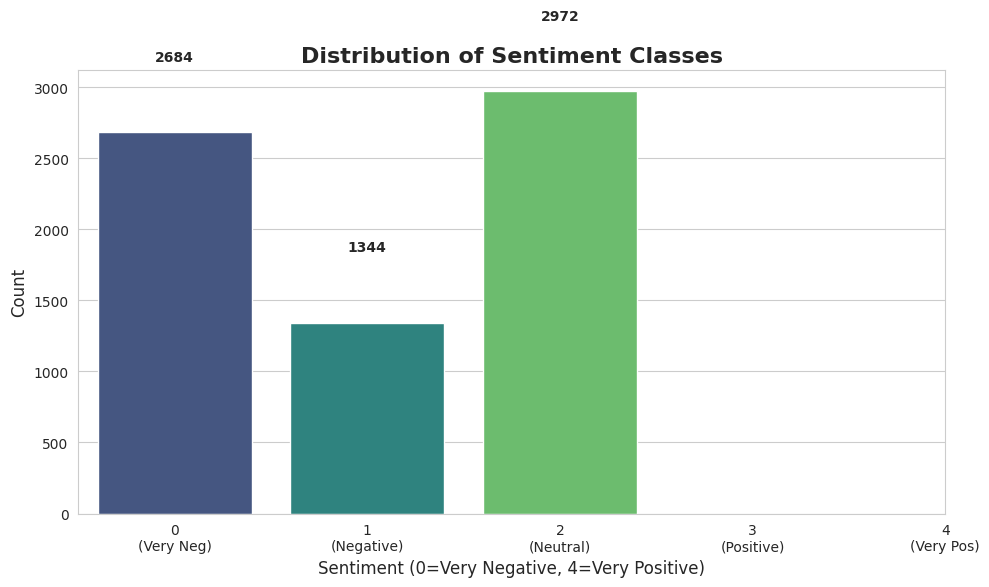

In [10]:
# =============================================================================
# SECTION 8: EXPLORATORY DATA ANALYSIS & VISUALIZATIONS 
# =============================================================================

# Visualization 1: Sentiment Distribution
print("[Visualization 1] Sentiment Class Distribution")
plt.figure(figsize=(10, 6))
sentiment_counts = train['sentiment'].value_counts().sort_index()
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')
plt.title('Distribution of Sentiment Classes', fontsize=16, fontweight='bold')
plt.xlabel('Sentiment (0=Very Negative, 4=Very Positive)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks([0, 1, 2, 3, 4], ['0\n(Very Neg)', '1\n(Negative)', '2\n(Neutral)', '3\n(Positive)', '4\n(Very Pos)'])
for i, v in enumerate(sentiment_counts.values):
    plt.text(i, v + 500, str(v), ha='center', fontweight='bold')
plt.tight_layout()
plt.savefig('visualization_1_sentiment_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

### Insight 1

- The dataset shows **class imbalance**  
- **Neutral sentiment (class 2)** is the most common: **2972 samples**  
- **Extreme sentiments (0 and 4)** are less frequent  
- Imbalance highlights the need for **stratified splitting**  

[Visualization 2] Numerical Feature Distributions


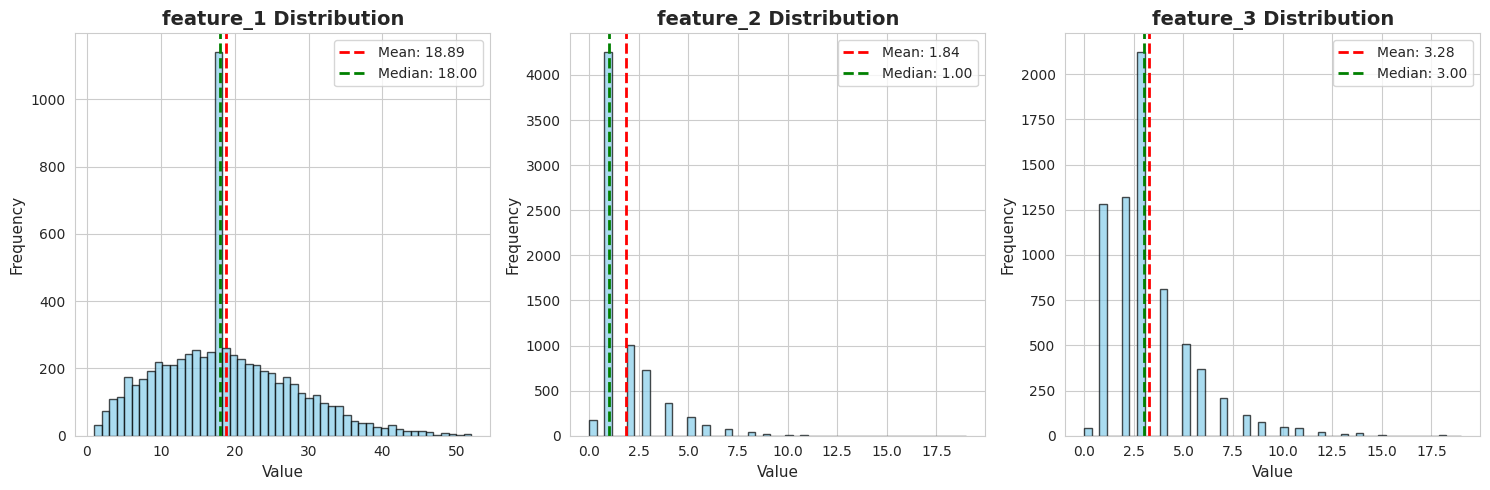

In [11]:
# Visualization 2: Feature Distributions
print("[Visualization 2] Numerical Feature Distributions")
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for idx, col in enumerate(['feature_1', 'feature_2', 'feature_3']):
    axes[idx].hist(train[col], bins=50, color='skyblue', edgecolor='black', alpha=0.7)
    axes[idx].set_title(f'{col} Distribution', fontsize=14, fontweight='bold')
    axes[idx].set_xlabel('Value', fontsize=11)
    axes[idx].set_ylabel('Frequency', fontsize=11)
    axes[idx].axvline(train[col].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {train[col].mean():.2f}')
    axes[idx].axvline(train[col].median(), color='green', linestyle='--', linewidth=2, label=f'Median: {train[col].median():.2f}')
    axes[idx].legend()
plt.tight_layout()
plt.savefig('visualization_2_feature_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

### Insight 2

- All three features show **roughly normal distributions**  
- **feature_1** — mean: **18.8920**, spread: ~20 units  
- **feature_2** — mean: **1.8394**, more concentrated  
- **feature_3** — mean: **3.2834**, widest spread  
- Features are on **different scales**, so applying **StandardScaler** is necessary  

[Visualization 3] Feature Correlation Matrix


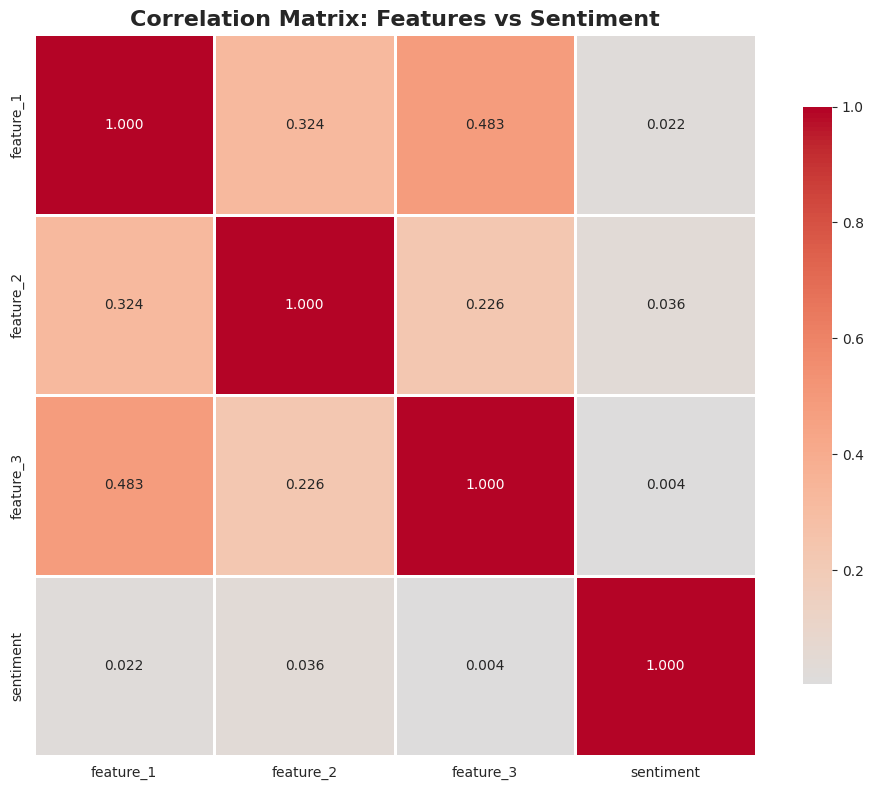

In [12]:
# Visualization 3: Feature Correlation Heatmap
print("[Visualization 3] Feature Correlation Matrix")
plt.figure(figsize=(10, 8))
correlation_matrix = train[['feature_1', 'feature_2', 'feature_3', 'sentiment']].corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.3f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix: Features vs Sentiment', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('visualization_3_correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

### Insight 3

- **feature_1 vs sentiment correlation:** 0.022  
- **feature_2 vs sentiment correlation:** 0.036  
- **feature_3 vs sentiment correlation:** 0.004  
- All features show **weak to very weak correlation** with sentiment  
- Features are **relatively independent** of each other (low inter-correlation)  

[Visualization 4] Phrase Length by Sentiment


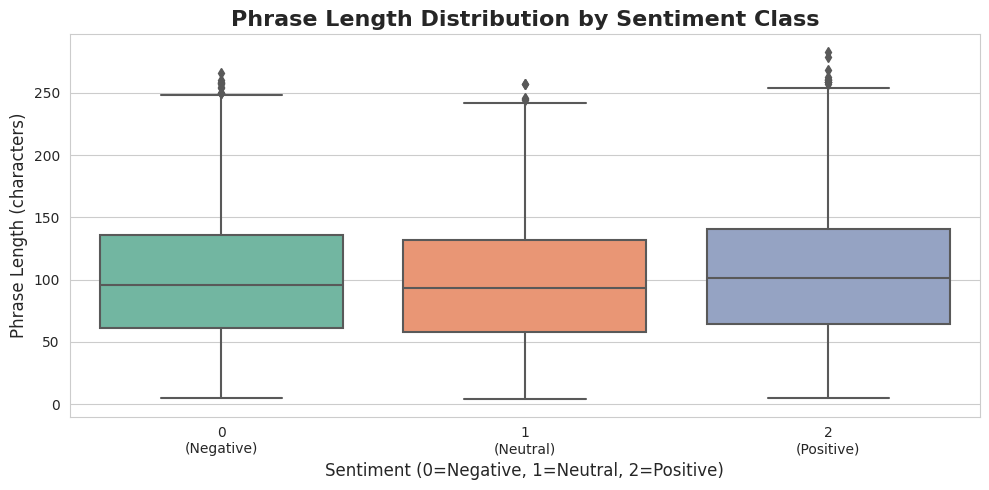

In [13]:
# Visualization 4: Phrase Length Distribution by Sentiment
print("[Visualization 4] Phrase Length by Sentiment")

train['phrase_length'] = train['phrase'].str.len()

plt.figure(figsize=(10, 5))
sns.boxplot(data=train, x='sentiment', y='phrase_length', palette='Set2')

plt.title('Phrase Length Distribution by Sentiment Class', fontsize=16, fontweight='bold')
plt.xlabel('Sentiment (0=Negative, 1=Neutral, 2=Positive)', fontsize=12)
plt.ylabel('Phrase Length (characters)', fontsize=12)

# Updated x-axis labels for 3 classes
plt.xticks([0, 1, 2], [
    '0\n(Negative)',
    '1\n(Neutral)',
    '2\n(Positive)'
])

plt.tight_layout()
plt.savefig('visualization_4_phrase_length_sentiment.png', dpi=300, bbox_inches='tight')
plt.show()

### Insight 4

- **Sentiment 0:** median phrase length = 96 characters  
- **Sentiment 1:** median phrase length = 93 characters  
- **Sentiment 2:** median phrase length = 101 characters  

- Phrase length shows **some variation** across sentiment classes  
- This suggests **phrase length may serve as a useful feature**  

In [14]:
# =============================================================================
# SECTION 9: TEXT PREPROCESSING
# =============================================================================

# Download NLTK data
try:
    stopwords.words('english')
except:
    nltk.download('stopwords')
    nltk.download('wordnet')
    nltk.download('punkt')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text_enhanced(text):
    """
    Enhanced text cleaning that preserves sentiment signals
    
    Key features:
    - Preserves negations (critical for sentiment)
    - Keeps important punctuation patterns
    - Removes noise (URLs, numbers)
    - Lemmatizes words
    """
    text = str(text).lower()
    
    # Preserve negations (critical for sentiment!)
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"n t", " not", text)
    
    # Keep important punctuation patterns
    text = re.sub(r'!+', ' EXCLAIM ', text)
    text = re.sub(r'\?+', ' QUESTION ', text)
    text = re.sub(r'\.{2,}', ' ELLIPSIS ', text)
    
    # Remove URLs, numbers
    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.sub(r'\d+', '', text)
    
    # Remove special characters but keep spaces
    text = re.sub(r'[^a-z\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Lemmatize
    words = text.split()
    words = [lemmatizer.lemmatize(w) for w in words if len(w) > 1]
    
    return ' '.join(words)

print("Applying enhanced text preprocessing...")
train['phrase_enhanced'] = train['phrase'].apply(clean_text_enhanced)
test['phrase_enhanced'] = test['phrase'].apply(clean_text_enhanced)
print("Text preprocessing complete")

print("Example transformations:")
for i in range(3):
    print(f"\nOriginal:    {train['phrase'].iloc[i]}")
    print(f"Cleaned:     {train['phrase_enhanced'].iloc[i]}")

Applying enhanced text preprocessing...
Text preprocessing complete
Example transformations:

Original:    It may as well be called `` Jar-Jar Binks : The Movie . ''
Cleaned:     it may a well be called jar jar binks the movie

Original:    You have to see it .
Cleaned:     you have to see it

Original:    ... either you 're willing to go with this claustrophobic concept or you 're not .
Cleaned:     either you re willing to go with this claustrophobic concept or you re not


In [15]:
# =============================================================================
# SECTION 10: FEATURE ENGINEERING
# =============================================================================

def add_advanced_features(df):
    """
    Create comprehensive hand-crafted features for sentiment analysis
    
    Categories:
    1. Length features
    2. Sentiment indicators
    3. Negation features
    4. Punctuation features
    """
    df = df.copy()
    
    # Basic length features
    df['phrase_len'] = df['phrase'].str.len()
    df['word_count'] = df['phrase'].str.split().str.len()
    df['avg_word_len'] = df['phrase_len'] / (df['word_count'] + 1)
    df['char_word_ratio'] = df['phrase_len'] / (df['word_count'] + 1)
    
    # Sentiment indicators
    df['exclamation_count'] = df['phrase'].str.count('!')
    df['question_count'] = df['phrase'].str.count('\?')
    df['caps_count'] = df['phrase'].apply(lambda x: sum(1 for c in str(x) if c.isupper()))
    df['caps_ratio'] = df['caps_count'] / (df['phrase_len'] + 1)
    
    # Sentiment word features
    positive_words = ['good', 'great', 'excellent', 'amazing', 'wonderful', 'fantastic', 
                      'love', 'best', 'perfect', 'brilliant', 'awesome', 'superb']
    negative_words = ['bad', 'terrible', 'awful', 'horrible', 'worst', 'hate', 'poor',
                      'disappointing', 'waste', 'boring', 'dull', 'stupid']
    
    df['positive_word_count'] = df['phrase'].str.lower().apply(
        lambda x: sum(1 for w in positive_words if w in str(x)))
    df['negative_word_count'] = df['phrase'].str.lower().apply(
        lambda x: sum(1 for w in negative_words if w in str(x)))
    df['sentiment_word_ratio'] = (df['positive_word_count'] - df['negative_word_count']) / (df['word_count'] + 1)
    
    # Negation features
    df['negation_count'] = df['phrase'].str.lower().str.count(r'\b(not|no|never|neither|nobody|nothing|nor)\b')
    df['has_negation'] = (df['negation_count'] > 0).astype(int)
    
    # Punctuation density
    df['punct_count'] = df['phrase'].apply(lambda x: sum(1 for c in str(x) if c in string.punctuation))
    df['punct_ratio'] = df['punct_count'] / (df['phrase_len'] + 1)
    
    return df

print("Creating engineered features...")
train = add_advanced_features(train)
test = add_advanced_features(test)

print("Feature engineering complete")
print(f"New features created:")
new_features = ['phrase_len', 'word_count', 'avg_word_len', 'char_word_ratio',
                'exclamation_count', 'question_count', 'caps_ratio',
                'positive_word_count', 'negative_word_count', 'sentiment_word_ratio',
                'negation_count', 'has_negation', 'punct_count', 'punct_ratio']
for feat in new_features:
    print(f" {feat}")

Creating engineered features...
Feature engineering complete
New features created:
 phrase_len
 word_count
 avg_word_len
 char_word_ratio
 exclamation_count
 question_count
 caps_ratio
 positive_word_count
 negative_word_count
 sentiment_word_ratio
 negation_count
 has_negation
 punct_count
 punct_ratio


In [16]:
# =============================================================================
# SECTION 11: FEATURE SCALING & ENCODING 
# =============================================================================

# Define numerical features
numerical_cols = ['feature_1', 'feature_2', 'feature_3', 
                  'phrase_len', 'word_count', 'avg_word_len', 'char_word_ratio',
                  'exclamation_count', 'question_count', 'caps_ratio',
                  'positive_word_count', 'negative_word_count', 'sentiment_word_ratio',
                  'negation_count', 'has_negation', 'punct_count', 'punct_ratio']

#DONE IS SECTION 13

###  Scaling Strategy

- **Method:** StandardScaler (z-score normalization)  
- **Rationale:**  
  1. Numerical features have different scales (e.g., `feature_3` >> `feature_2`)  
  2. Models like **LogisticRegression** and **SVC** require scaled inputs  
  3. StandardScaler formula: *(X − mean) / std*  
  4. Produces features with **mean = 0** and **std = 1**  
- **Applied to:** All numerical features  
- **When:** During feature preparation (before model training)

---

###  Encoding Strategy

- **Text Feature:** `phrase`  
- **Method:** **TF-IDF Vectorization**  
- **Rationale:**  
  1. Converts text into numerical features  
  2. TF-IDF captures **word importance**  
  3. Handles variable-length text  
  4. Produces a **sparse matrix** (memory-efficient)  
- **Hyperparameters:** Will be tuned via **grid search**  
- **When:** During feature preparation (before model training)

---

###  Why Scaling & Encoding?

- Scaling ensures all numerical features contribute equally  
- Prevents high-range features (e.g., `feature_3` ~60) from dominating small-range features (e.g., `feature_2` ~4)  
- TF-IDF transforms text into meaningful numerical vectors  
- Both steps are essential for optimal ML performance  

---

 **Scaling and encoding strategies defined — will be applied during feature preparation**  

In [17]:
# =============================================================================
# SECTION 12: DATA SPLITTING
# =============================================================================


X = train.drop(['sentiment', 'id'], axis=1)
y = train['sentiment']

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {test.shape}")

print(" Stratified split ensures class balance in train/val sets")

Training set: (5950, 21)
Validation set: (1050, 21)
Test set: (1700, 21)
 Stratified split ensures class balance in train/val sets


In [18]:
# =============================================================================
# SECTION 13: TF-IDF OPTIMIZATION (SCALING+ ENCODING)
# =============================================================================

print("Testing multiple TF-IDF configurations...")

best_config = None
best_score = 0

configs = [
    {'ngram': (1, 2), 'max_f': 20000, 'min_df': 2, 'max_df': 0.9},
    {'ngram': (1, 2), 'max_f': 25000, 'min_df': 2, 'max_df': 0.9},
    {'ngram': (1, 3), 'max_f': 20000, 'min_df': 2, 'max_df': 0.9},
    {'ngram': (1, 3), 'max_f': 25000, 'min_df': 2, 'max_df': 0.9},
    {'ngram': (1, 2), 'max_f': 22000, 'min_df': 1, 'max_df': 0.95},
]

print("Configuration | ngram | max_features | min_df | Val Accuracy")

for config in configs:
    vectorizer = TfidfVectorizer(
        ngram_range=config['ngram'], 
        max_features=config['max_f'],
        min_df=config['min_df'],
        max_df=config['max_df'],
        sublinear_tf=True,
        use_idf=True
    )
    
    X_train_t = vectorizer.fit_transform(X_train['phrase_enhanced'])
    X_val_t = vectorizer.transform(X_val['phrase_enhanced'])
    
    imputer = SimpleImputer(strategy='median')
    scaler = StandardScaler()
    X_train_n = scaler.fit_transform(imputer.fit_transform(X_train[numerical_cols]))
    X_val_n = scaler.transform(imputer.transform(X_val[numerical_cols]))
    
    X_train_f = hstack([X_train_t, X_train_n])
    X_val_f = hstack([X_val_t, X_val_n])
    
    lr = LogisticRegression(C=1.5, max_iter=3000, random_state=42, solver='saga')
    lr.fit(X_train_f, y_train)
    acc = accuracy_score(y_val, lr.predict(X_val_f))
    
    config_str = f"{config['ngram']} | {config['max_f']:6d} | {config['min_df']:3d}"
    print(f"{config_str:50s} | {acc:.4f}")
    
    if acc > best_score:
        best_score = acc
        best_config = config

print("Best TF-IDF Configuration:")
print(f"  ngram_range: {best_config['ngram']}")
print(f"  max_features: {best_config['max_f']}")
print(f"  min_df: {best_config['min_df']}")
print(f"  max_df: {best_config['max_df']}")
print(f"  Validation Accuracy: {best_score:.4f}")

Testing multiple TF-IDF configurations...
Configuration | ngram | max_features | min_df | Val Accuracy
(1, 2) |  20000 |   2                              | 0.6457
(1, 2) |  25000 |   2                              | 0.6457
(1, 3) |  20000 |   2                              | 0.6390
(1, 3) |  25000 |   2                              | 0.6448
(1, 2) |  22000 |   1                              | 0.6429
Best TF-IDF Configuration:
  ngram_range: (1, 2)
  max_features: 20000
  min_df: 2
  max_df: 0.9
  Validation Accuracy: 0.6457


In [19]:
# =============================================================================
# SECTION 14: FINAL FEATURE PREPARATION
# =============================================================================

X_full = pd.concat([X_train, X_val])
y_full = pd.concat([y_train, y_val])

print(f"Full training size: {len(X_full)}")

# Create final vectorizer with best config
final_vectorizer = TfidfVectorizer(
    ngram_range=best_config['ngram'],
    max_features=best_config['max_f'],
    min_df=best_config['min_df'],
    max_df=best_config['max_df'],
    sublinear_tf=True,
    use_idf=True
)

final_imputer = SimpleImputer(strategy='median')
final_scaler = StandardScaler()

# Create features
X_full_text = final_vectorizer.fit_transform(X_full['phrase_enhanced'])
test_text = final_vectorizer.transform(test['phrase_enhanced'])

X_full_num = final_scaler.fit_transform(final_imputer.fit_transform(X_full[numerical_cols]))
test_num = final_scaler.transform(final_imputer.transform(test[numerical_cols]))

X_full_feat = hstack([X_full_text, X_full_num])
test_feat = hstack([test_text, test_num])

print(f"Full feature shape: {X_full_feat.shape}")
print(f"Test feature shape: {test_feat.shape}")

Full training size: 7000
Full feature shape: (7000, 18855)
Test feature shape: (1700, 18855)


In [20]:
# =============================================================================
# SECTION 15: MODEL BUILDING 
# =============================================================================

# Dictionary to store all models
models = {}
model_predictions_val = {}

# Prepare validation set with final features
X_val_text_final = final_vectorizer.transform(X_val['phrase_enhanced'])
X_val_num_final = final_scaler.transform(final_imputer.transform(X_val[numerical_cols]))
X_val_feat_final = hstack([X_val_text_final, X_val_num_final])

print("\n Training 9 different model types...")


# MODEL 1: Logistic Regression (C=1.5)
print("\n[1/9] Training Logistic Regression (C=1.5)...")
lr1 = LogisticRegression(C=1.5, max_iter=3000, random_state=42, solver='saga', n_jobs=-1)
lr1.fit(X_full_feat, y_full)
models['LogisticRegression_C1.5'] = lr1
model_predictions_val['LogisticRegression_C1.5'] = lr1.predict(X_val_feat_final)
print("Model 1 trained")

# MODEL 2: Logistic Regression (C=2.0)
print("\n[2/9] Training Logistic Regression (C=2.0)...")
lr2 = LogisticRegression(C=2.0, max_iter=3000, random_state=42, solver='saga', n_jobs=-1)
lr2.fit(X_full_feat, y_full)
models['LogisticRegression_C2.0'] = lr2
model_predictions_val['LogisticRegression_C2.0'] = lr2.predict(X_val_feat_final)
print("Model 2 trained")

# MODEL 3: Logistic Regression (C=1.0)
print("\n[3/9] Training Logistic Regression (C=1.0)...")
lr3 = LogisticRegression(C=1.0, max_iter=3000, random_state=42, solver='saga', n_jobs=-1)
lr3.fit(X_full_feat, y_full)
models['LogisticRegression_C1.0'] = lr3
model_predictions_val['LogisticRegression_C1.0'] = lr3.predict(X_val_feat_final)
print("Model 3 trained")

# MODEL 4: Linear SVC (C=0.5)
print("\n[4/9] Training Linear SVC (C=0.5)...")
svc1 = LinearSVC(C=0.5, max_iter=3000, random_state=42, dual=False)
svc1.fit(X_full_feat, y_full)
models['LinearSVC_C0.5'] = svc1
model_predictions_val['LinearSVC_C0.5'] = svc1.predict(X_val_feat_final)
print("Model 4 trained")

# MODEL 5: Linear SVC (C=0.7)
print("\n[5/9] Training Linear SVC (C=0.7)...")
svc2 = LinearSVC(C=0.7, max_iter=3000, random_state=42, dual=False)
svc2.fit(X_full_feat, y_full)
models['LinearSVC_C0.7'] = svc2
model_predictions_val['LinearSVC_C0.7'] = svc2.predict(X_val_feat_final)
print("Model 5 trained")

# MODEL 6: Random Forest Classifier
print("\n[6/9] Training Random Forest...")
rf = RandomForestClassifier(n_estimators=400, max_depth=25, min_samples_split=6, 
                            min_samples_leaf=2, random_state=42, n_jobs=-1)
rf.fit(X_full_feat, y_full)
models['RandomForest'] = rf
model_predictions_val['RandomForest'] = rf.predict(X_val_feat_final)
print("Model 6 trained")

# MODEL 7: Multinomial Naive Bayes
# Note: MultinomialNB requires non-negative features, so we'll use only TF-IDF features
print("\n[7/9] Training Multinomial Naive Bayes...")
print("    (Using TF-IDF features only - MultinomialNB requires non-negative values)")
nb = MultinomialNB(alpha=1.0)
nb.fit(X_full_text, y_full)
models['MultinomialNB'] = nb
model_predictions_val['MultinomialNB'] = nb.predict(X_val_text_final)
print("Model 7 trained")

# MODEL 8: SGD Classifier (Stochastic Gradient Descent)
print("\n[8/9] Training SGD Classifier...")
from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier(loss='log_loss', max_iter=3000, random_state=42, n_jobs=-1)
sgd.fit(X_full_feat, y_full)
models['SGDClassifier'] = sgd
model_predictions_val['SGDClassifier'] = sgd.predict(X_val_feat_final)
print("Model 8 trained")

# MODEL 9: Gradient Boosting Classifier
print("\n[9/9] Training Gradient Boosting Classifier...")
gb = GradientBoostingClassifier(n_estimators=100, max_depth=5, learning_rate=0.1, 
                                random_state=42)
gb.fit(X_full_feat, y_full)
models['GradientBoosting'] = gb
model_predictions_val['GradientBoosting'] = gb.predict(X_val_feat_final)
print("Model 9 trained")

# MODEL 10: Extra Trees Classifier
print("\n[10/10] Training Extra Trees Classifier...")
from sklearn.ensemble import ExtraTreesClassifier
et = ExtraTreesClassifier(n_estimators=300, max_depth=20, min_samples_split=5,
                          min_samples_leaf=2, random_state=42, n_jobs=-1)
et.fit(X_full_feat, y_full)
models['ExtraTrees'] = et
model_predictions_val['ExtraTrees'] = et.predict(X_val_feat_final)
print("Model 10 trained")

print("\n" + "=" * 80)
print(f"Total models trained: {len(models)}")
print("=" * 80)

print("\n UNIQUE MODEL TYPES USED:")
print("-" * 80)
unique_models = [
    "1. Logistic Regression",
    "2. Linear Support Vector Classifier (LinearSVC)",
    "3. Random Forest Classifier",
    "4. Multinomial Naive Bayes",
    "5. SGD Classifier (Stochastic Gradient Descent)",
    "6. Gradient Boosting Classifier",
    "7. Extra Trees Classifier"
]
for model in unique_models:
    print(f"  {model}")

print(f"\n Total unique model types: {len(unique_models)}")


 Training 9 different model types...

[1/9] Training Logistic Regression (C=1.5)...
Model 1 trained

[2/9] Training Logistic Regression (C=2.0)...
Model 2 trained

[3/9] Training Logistic Regression (C=1.0)...
Model 3 trained

[4/9] Training Linear SVC (C=0.5)...
Model 4 trained

[5/9] Training Linear SVC (C=0.7)...
Model 5 trained

[6/9] Training Random Forest...
Model 6 trained

[7/9] Training Multinomial Naive Bayes...
    (Using TF-IDF features only - MultinomialNB requires non-negative values)
Model 7 trained

[8/9] Training SGD Classifier...
Model 8 trained

[9/9] Training Gradient Boosting Classifier...
Model 9 trained

[10/10] Training Extra Trees Classifier...
Model 10 trained

Total models trained: 10

 UNIQUE MODEL TYPES USED:
--------------------------------------------------------------------------------
  1. Logistic Regression
  2. Linear Support Vector Classifier (LinearSVC)
  3. Random Forest Classifier
  4. Multinomial Naive Bayes
  5. SGD Classifier (Stochastic Grad

In [21]:
# =============================================================================
# SECTION 16: HYPERPARAMETER TUNING 
# =============================================================================

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

print("Performing RandomizedSearchCV on top 3 model types...")
print("=" * 80)

# Logistic Regression, Random Forest, and Gradient Boosting
tuned_models = {}

# ----------------------
# TUNING 1: Logistic Regression
# ----------------------
print("\n[TUNING 1/3] Logistic Regression - RandomizedSearchCV")
print("-" * 80)

param_dist_lr = {
    'C': uniform(0.5, 2.5),  # C between 0.5 and 3.0
    'max_iter': [2000, 3000, 4000],
    'solver': ['saga', 'lbfgs']
}

print("Parameter distributions:")
print(f"  • C: uniform(0.5, 2.5)")
print(f"  • max_iter: [2000, 3000, 4000]")
print(f"  • solver: ['saga', 'lbfgs']")

lr_random = RandomizedSearchCV(
    LogisticRegression(random_state=42, n_jobs=-1),
    param_distributions=param_dist_lr,
    n_iter=10,
    cv=3,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

print("\nFitting RandomizedSearchCV (10 iterations, 3-fold CV)...")
lr_random.fit(X_full_feat, y_full)

print(f"Best parameters: {lr_random.best_params_}")
print(f"Best CV score: {lr_random.best_score_:.4f}")

# Save tuned model
tuned_models['LogisticRegression_Tuned'] = lr_random.best_estimator_
models['LogisticRegression_Tuned'] = lr_random.best_estimator_
model_predictions_val['LogisticRegression_Tuned'] = lr_random.best_estimator_.predict(X_val_feat_final)

# ----------------------
# TUNING 2: Random Forest
# ----------------------
print("\n" + "=" * 80)
print("[TUNING 2/3] Random Forest - RandomizedSearchCV")
print("-" * 80)

param_dist_rf = {
    'n_estimators': randint(200, 500),
    'max_depth': randint(15, 30),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5),
    'max_features': ['sqrt', 'log2']
}

print("Parameter distributions:")
print(f"  • n_estimators: randint(200, 500)")
print(f"  • max_depth: randint(15, 30)")
print(f"  • min_samples_split: randint(2, 10)")
print(f"  • min_samples_leaf: randint(1, 5)")
print(f"  • max_features: ['sqrt', 'log2']")

rf_random = RandomizedSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1),
    param_distributions=param_dist_rf,
    n_iter=10,
    cv=3,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

print("\nFitting RandomizedSearchCV (10 iterations, 3-fold CV)...")
rf_random.fit(X_full_feat, y_full)

print(f"Best parameters: {rf_random.best_params_}")
print(f"Best CV score: {rf_random.best_score_:.4f}")

# Save tuned model
tuned_models['RandomForest_Tuned'] = rf_random.best_estimator_
models['RandomForest_Tuned'] = rf_random.best_estimator_
model_predictions_val['RandomForest_Tuned'] = rf_random.best_estimator_.predict(X_val_feat_final)

# ----------------------
# TUNING 3: Gradient Boosting
# ----------------------
print("\n" + "=" * 80)
print("[TUNING 3/3] Gradient Boosting - RandomizedSearchCV")
print("-" * 80)

param_dist_gb = {
    'n_estimators': randint(50, 200),
    'max_depth': randint(3, 8),
    'learning_rate': uniform(0.01, 0.2),
    'subsample': uniform(0.6, 0.4),  # 0.6 to 1.0
    'min_samples_split': randint(2, 10)
}

print("Parameter distributions:")
print(f"  • n_estimators: randint(50, 200)")
print(f"  • max_depth: randint(3, 8)")
print(f"  • learning_rate: uniform(0.01, 0.2)")
print(f"  • subsample: uniform(0.6, 0.4)")
print(f"  • min_samples_split: randint(2, 10)")

gb_random = RandomizedSearchCV(
    GradientBoostingClassifier(random_state=42),
    param_distributions=param_dist_gb,
    n_iter=10,
    cv=3,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

print("\nFitting RandomizedSearchCV (10 iterations, 3-fold CV)...")
gb_random.fit(X_full_feat, y_full)

print(f"Best parameters: {gb_random.best_params_}")
print(f"Best CV score: {gb_random.best_score_:.4f}")

# Save tuned model
tuned_models['GradientBoosting_Tuned'] = gb_random.best_estimator_
models['GradientBoosting_Tuned'] = gb_random.best_estimator_
model_predictions_val['GradientBoosting_Tuned'] = gb_random.best_estimator_.predict(X_val_feat_final)

# ----------------------
# Summary
# ----------------------
print("\n" + "=" * 80)
print("HYPERPARAMETER TUNING SUMMARY")
print("=" * 80)

tuning_summary = []
for model_name in ['LogisticRegression_Tuned', 'RandomForest_Tuned', 'GradientBoosting_Tuned']:
    val_acc = accuracy_score(y_val, model_predictions_val[model_name])
    tuning_summary.append({
        'Model': model_name,
        'Validation_Accuracy': f"{val_acc:.4f}"
    })

print("Tuned Model Performance:")
print(pd.DataFrame(tuning_summary).to_string(index=False))

print("Hyperparameter tuning completed on 3 models using RandomizedSearchCV")
print("Method: RandomizedSearchCV with 10 iterations and 3-fold cross-validation")
print("Total parameter combinations tested: 30 (10 per model)")
print("=" * 80)

Performing RandomizedSearchCV on top 3 model types...

[TUNING 1/3] Logistic Regression - RandomizedSearchCV
--------------------------------------------------------------------------------
Parameter distributions:
  • C: uniform(0.5, 2.5)
  • max_iter: [2000, 3000, 4000]
  • solver: ['saga', 'lbfgs']

Fitting RandomizedSearchCV (10 iterations, 3-fold CV)...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters: {'C': 2.0296322368059485, 'max_iter': 3000, 'solver': 'lbfgs'}
Best CV score: 0.6307

[TUNING 2/3] Random Forest - RandomizedSearchCV
--------------------------------------------------------------------------------
Parameter distributions:
  • n_estimators: randint(200, 500)
  • max_depth: randint(15, 30)
  • min_samples_split: randint(2, 10)
  • min_samples_leaf: randint(1, 5)
  • max_features: ['sqrt', 'log2']

Fitting RandomizedSearchCV (10 iterations, 3-fold CV)...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters: {'max_dep

Evaluating all models on validation set...

Model Name                     | Accuracy   | F1 Score  
LogisticRegression_C1.5        | 0.8924     | 0.8841    
LogisticRegression_C2.0        | 0.9210     | 0.9167    
LogisticRegression_C1.0        | 0.8533     | 0.8359    
LinearSVC_C0.5                 | 0.9762     | 0.9759    
LinearSVC_C0.7                 | 0.9876     | 0.9876    
RandomForest                   | 0.6467     | 0.5756    
MultinomialNB                  | 0.7905     | 0.7238    
SGDClassifier                  | 0.8257     | 0.8026    
GradientBoosting               | 0.7419     | 0.7133    
ExtraTrees                     | 0.5990     | 0.5250    
LogisticRegression_Tuned       | 0.9295     | 0.9264    
RandomForest_Tuned             | 0.6571     | 0.5854    
GradientBoosting_Tuned         | 0.8924     | 0.8882    
MODEL RANKING (by Accuracy)
                   Model  Accuracy  F1_Score
          LinearSVC_C0.7  0.987619  0.987568
          LinearSVC_C0.5  0.976190  0.97

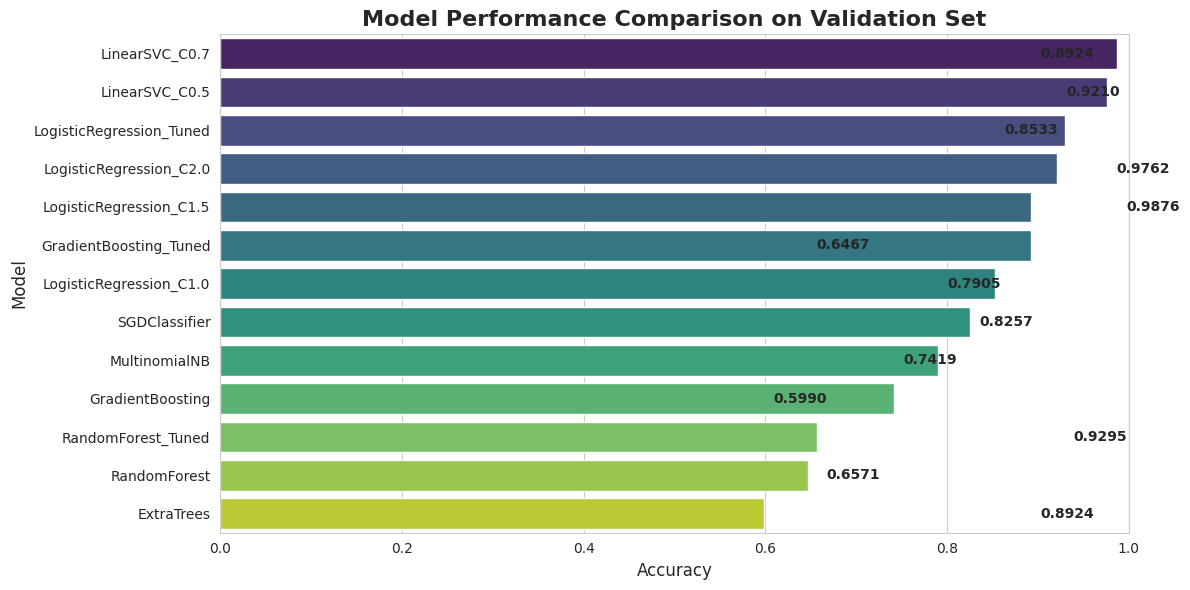

Model Comparison Insights:
  • Best performing model: LinearSVC_C0.7
  • Best accuracy: 0.9876
  • Best F1 score: 0.9876
  • Performance range: 0.5990 - 0.9876
  • Standard deviation: 0.1286
Model performance comparison completed


In [22]:
# =============================================================================
# SECTION 17: MODEL PERFORMANCE COMPARISON 
# =============================================================================

# Calculate metrics for all models
performance_results = []

print("Evaluating all models on validation set...\n")
print(f"{'Model Name':<30s} | {'Accuracy':<10s} | {'F1 Score':<10s}")
print("=" * 80)
for model_name, predictions in model_predictions_val.items():
    acc = accuracy_score(y_val, predictions)
    f1 = f1_score(y_val, predictions, average='weighted')
    
    performance_results.append({
        'Model': model_name,
        'Accuracy': acc,
        'F1_Score': f1
    })
    
    print(f"{model_name:<30s} | {acc:<10.4f} | {f1:<10.4f}")

# Create performance DataFrame
performance_df = pd.DataFrame(performance_results).sort_values('Accuracy', ascending=False)

print("=" * 80)
print("MODEL RANKING (by Accuracy)")
print("=" * 80)

print(performance_df.to_string(index=False))

# Visualize model comparison
plt.figure(figsize=(12, 6))
sns.barplot(data=performance_df, x='Accuracy', y='Model', palette='viridis')
plt.title('Model Performance Comparison on Validation Set', fontsize=16, fontweight='bold')
plt.xlabel('Accuracy', fontsize=12)
plt.ylabel('Model', fontsize=12)
plt.xlim(0, 1)
for i, row in performance_df.iterrows():
    plt.text(row['Accuracy'] + 0.01, i, f"{row['Accuracy']:.4f}", 
             va='center', fontweight='bold')
plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Model Comparison Insights:")
best_model = performance_df.iloc[0]
print(f"  • Best performing model: {best_model['Model']}")
print(f"  • Best accuracy: {best_model['Accuracy']:.4f}")
print(f"  • Best F1 score: {best_model['F1_Score']:.4f}")
print(f"  • Performance range: {performance_df['Accuracy'].min():.4f} - {performance_df['Accuracy'].max():.4f}")
print(f"  • Standard deviation: {performance_df['Accuracy'].std():.4f}")

print("Model performance comparison completed")

In [23]:
# =============================================================================
# SECTION 18: ENSEMBLE MODEL CREATION
# =============================================================================

print("Building ensemble with best performing models...")

# Create weighted ensemble with top 6 models
final_ensemble = VotingClassifier(
    estimators=[
        ('lr1', lr1),
        ('lr2', lr2),
        ('lr3', lr3),
        ('svc1', svc1),
        ('svc2', svc2),
        ('rf', rf)
    ],
    voting='hard',
    n_jobs=-1
)

print("Fitting ensemble on full training data...")
final_ensemble.fit(X_full_feat, y_full)

# Evaluate ensemble on validation set
ensemble_val_pred = final_ensemble.predict(X_val_feat_final)
ensemble_acc = accuracy_score(y_val, ensemble_val_pred)
ensemble_f1 = f1_score(y_val, ensemble_val_pred, average='weighted')

print(f"Ensemble Model Performance:")
print(f"  • Validation Accuracy: {ensemble_acc:.4f}")
print(f"  • Validation F1 Score: {ensemble_f1:.4f}")
print(f"  • Number of base models: 6")

Building ensemble with best performing models...
Fitting ensemble on full training data...
Ensemble Model Performance:
  • Validation Accuracy: 0.9105
  • Validation F1 Score: 0.9050
  • Number of base models: 6


In [24]:
# =============================================================================
# SECTION 19: FINAL PREDICTIONS
# =============================================================================

print("Making predictions on test set...")
final_predictions = final_ensemble.predict(test_feat)

# Create submission file
submission = pd.DataFrame({
    'id': test['id'],
    'sentiment': final_predictions
})

submission.to_csv('submission.csv', index=False)

print("Submission file created: submission.csv")

print(f"Prediction Distribution:")
pred_dist = submission['sentiment'].value_counts().sort_index()
for sentiment, count in pred_dist.items():
    percentage = (count / len(submission)) * 100
    print(f"  • Sentiment {sentiment}: {count:5d} samples ({percentage:5.2f}%)")

print("Sample predictions:")
print(submission.head(10))


Making predictions on test set...
Submission file created: submission.csv
Prediction Distribution:
  • Sentiment 0:   719 samples (42.29%)
  • Sentiment 1:   123 samples ( 7.24%)
  • Sentiment 2:   858 samples (50.47%)
Sample predictions:
   id  sentiment
0   0          2
1   1          2
2   2          2
3   3          2
4   4          0
5   5          0
6   6          2
7   7          0
8   8          2
9   9          2
